# Todo

## MAGIC dataset
* kNN
* LR(?)
* NN using tensorflow
* XGBoost
* PCA
* Rerun methods
* Write report comparing methods and discussing importance of PCA for ten features (19020 datapoints) where some have correlation

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.neighbors as sklne
import sklearn.model_selection as sklms
import sklearn.preprocessing as sklpre
import tensorflow as tf
import seaborn as sns
import scikitplot as sklplt
import sklearn.metrics as sklme
import tensorflow_addons as tfa
import xgboost as xgb
import sklearn.decomposition as sklde
import skopt
import joblib

fonts = {
    "font.family": "serif",
    "axes.labelsize": 10,
    "font.size": 10,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
}

plt.rcParams.update(fonts)

np.random.seed(123)

<IPython.core.display.Javascript object>

In [21]:
# Black for Jupyter Notebook!
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

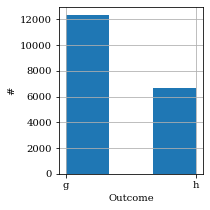

<IPython.core.display.Javascript object>

In [22]:
# Reading data
df = pd.read_csv("data/telescope_data.csv")
# Dropping useless column
df.drop("Unnamed: 0", axis=1, inplace=True)
# Setting feature matrix X and outcome y
X = df.drop("class", axis=1)
y = df["class"]

# Splitting
X_train, X_test, y_train, y_test = sklms.train_test_split(
    X, y, stratify=y, test_size=0.33
)

# Scaling feature matrix (All features are scalar).
scaler = sklpre.StandardScaler()

X_train = pd.DataFrame(
    scaler.fit_transform(X_train.to_numpy()), columns=X_train.columns
)
X_test = pd.DataFrame(scaler.transform(X_test.to_numpy()), columns=X_test.columns)

# One-hot encoding outcomes, keeping them as dataframes
encoder = sklpre.OneHotEncoder(categories="auto", sparse=False)
# Plotting histogram of outcomes
fig, ax = plt.subplots(figsize=(3.01682, 3.01682))
y.hist(ax=ax, density=False, bins=3)

y_train = pd.DataFrame(
    encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)),
    columns=encoder.categories_,
)
y_test = pd.DataFrame(
    encoder.fit_transform(y_test.to_numpy().reshape(-1, 1)),
    columns=encoder.categories_,
)
ax.set_xlabel("Outcome")
ax.set_ylabel("Occurences")
fig.tight_layout()
fig.savefig("../doc/figures/histogram.pdf", dpi=1000)
plt.show()
# Deleting non-used objects to avoid bugs later and save memory
del X
del y
del df

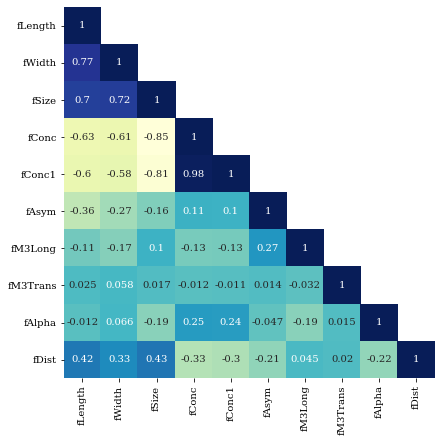

<IPython.core.display.Javascript object>

In [23]:
# Plotting correlation matrix
fig, ax = plt.subplots(figsize=(6.24123, 6.24123))
X_train_corr = X_train.corr()
mask = np.triu(X_train_corr, k=1)
mask = np.ma.array(X_train_corr.to_numpy(), mask=mask)
X_train_corr = pd.DataFrame(
    mask, columns=X_train_corr.columns, index=X_train_corr.index,
)
sns.heatmap(X_train_corr, cmap="YlGnBu", ax=ax, square=True, annot=True, cbar=False)
ax.set_ylim([10, 0])
ax.set_xlim([0, 10])
fig.tight_layout()
fig.savefig("../doc/figures/correlation_matrix_train.pdf", dpi=1000)
plt.show()

# kNN

In [24]:
knn_base = sklne.KNeighborsClassifier()

hyperparams_knn = {"n_neighbors": np.arange(1, 50)}
# As we saw in the earlier plot, we have an imbalanced dataset. Therefore we use the F1 score instead of accuracy
grid_search_knn = sklms.GridSearchCV(
    knn_base,
    hyperparams_knn,
    scoring="f1_weighted",
    cv=5,
    iid=False,
    n_jobs=-1,
    verbose=0,
).fit(X_train, y_train)

<IPython.core.display.Javascript object>

k-NN:
Train weighted f1 score: 0.88
Test weighted f1 score: 0.83
Best k = 5


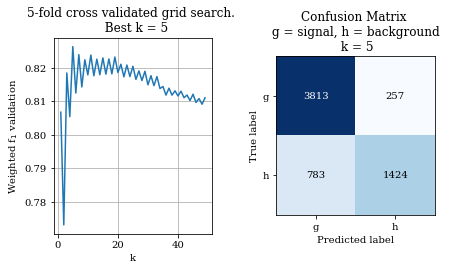

<IPython.core.display.Javascript object>

In [25]:
print("k-NN:")
print(f"Train weighted f1 score: {grid_search_knn.score(X_train, y_train):.2f}")
print(f"Test weighted f1 score: {grid_search_knn.score(X_test, y_test):.2f}")
print(f"Best k = {grid_search_knn.best_params_['n_neighbors']}")
fig, ax = plt.subplots(1, 2, figsize=[6.24123, 6.24123 / 1.618])
y_pred_test = encoder.inverse_transform(grid_search_knn.predict(X_test))
sklplt.metrics.plot_confusion_matrix(
    encoder.inverse_transform(y_test.to_numpy()),
    y_pred_test,
    ax=ax[1],
    hide_counts=False,
    normalize=False,
    title=f"Confusion Matrix "
    + f"\n g = signal, h = background "
    + f"\n k = {grid_search_knn.best_params_['n_neighbors']}",
)
# Scikit-plot doesn't let you disable colorbar, removing it manually
im = ax[1].images
cb = im[-1].colorbar
cb.remove()
ax[1].set_ylim([1.5, -0.5])
ax[1].set_xlim([-0.5, 1.5])
ax[0].plot(
    hyperparams_knn["n_neighbors"], grid_search_knn.cv_results_["mean_test_score"]
)
ax[0].set_xlabel("k")
ax[0].set_ylabel(r"Weighted f$_1$ validation")
ax[0].grid()
ax[0].set_title(
    f"5-fold cross validated grid search. \n  Best k = {grid_search_knn.best_params_['n_neighbors']}"
)
# fig.suptitle(fr"k Nearest Neighbors.")

fig.tight_layout()  # (rect=[0, 0.03, 1, 0.95])
fig.savefig("../doc/figures/kNN_cv_results.pdf", dpi=1000)
plt.show()

# Tensorflow neural network
## Setting hyperparameters based on validation f1

In [26]:
X_train_split, X_validation, y_train_split, y_validation = sklms.train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train
)
X_train_split = X_train_split.to_numpy()
X_validation = X_validation.to_numpy()

y_train_split = y_train_split.to_numpy()

y_validation = y_validation.to_numpy()

<IPython.core.display.Javascript object>

In [27]:
batch_sizes = skopt.space.Integer(low=1, high=200, name="batch_size")
dropout_1 = skopt.space.Real(low=0, high=0.5, name="dropout_1")
dropout_2 = skopt.space.Real(low=0, high=0.5, name="dropout_2")
nodes_1 = skopt.space.Integer(low=1, high=20, name="nodes_1")
nodes_2 = skopt.space.Integer(low=1, high=10, name="nodes_2")
space = [batch_sizes, dropout_1, dropout_2, nodes_1, nodes_2]


@skopt.utils.use_named_args(dimensions=space)
def neural_network_fit(
    batch_size, dropout_1, dropout_2, nodes_1, nodes_2, return_epochs=False
):
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=3, verbose=1, restore_best_weights=True
    )
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Dense(nodes_1, activation="relu"),
            tf.keras.layers.Dropout(dropout_1),
            tf.keras.layers.Dense(nodes_2, activation="relu"),
            tf.keras.layers.Dropout(dropout_2),
            tf.keras.layers.Dense(2, activation="softmax"),
        ]
    )
    model.compile(
        optimizer="adam", loss="categorical_crossentropy",
    )

    model.fit(
        X_train_split,
        y_train_split,
        epochs=100,
        batch_size=batch_size,
        validation_data=(X_validation, y_validation),
        verbose=0,
        callbacks=[early_stop],
    )
    if return_epochs:
        print("jeff")
        return early_stop.stopped_epoch
    y_pred_validation_nn = model.predict_classes(X_validation).reshape(-1, 1)
    y_pred_validation_nn = np.append(
        y_pred_validation_nn == 0, y_pred_validation_nn == 1, axis=1
    ).astype(np.int)
    f1_score_weighted_validation = sklme.f1_score(
        y_true=y_validation, y_pred=y_pred_validation_nn, average="weighted"
    )

    return 1 - f1_score_weighted_validation


n_points = 1000
optimizer_nn = skopt.gp_minimize(
    func=neural_network_fit,
    dimensions=space,
    n_jobs=-1,
    verbose=True,
    n_calls=n_points,
    n_random_starts=n_points,
)

Iteration No: 1 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.7030
Function value obtained: 0.1529
Current minimum: 0.1529
Iteration No: 2 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 5.2509
Function value obtained: 0.1811
Current minimum: 0.1529
Iteration No: 3 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 2.1631
Function value obtained: 0.2128
Current minimum: 0.1529
Iteration No: 4 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping
Iteration No: 4 ended. 

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Iteration No: 31 ended. Evaluation done at random point.
Time taken: 6.5630
Function value obtained: 0.1555
Current minimum: 0.1366
Iteration No: 32 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Iteration No: 32 ended. Evaluation done at random point.
Time taken: 15.7344
Function value obtained: 0.1437
Current minimum: 0.1366
Iteration No: 33 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
Iteration No: 33 ended. Evaluation done at random point.
Time taken: 48.9769
Function value obtained: 0.1648
Current minimum: 0.1366
Iteration No: 34 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
Iteration No: 34 ended. Evaluation done at random point.
Time taken: 16.9518


Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Iteration No: 61 ended. Evaluation done at random point.
Time taken: 4.4227
Function value obtained: 0.1613
Current minimum: 0.1363
Iteration No: 62 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Iteration No: 62 ended. Evaluation done at random point.
Time taken: 2.5510
Function value obtained: 0.4896
Current minimum: 0.1363
Iteration No: 63 started. Evaluating function at random point.


/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00067: early stopping
Iteration No: 63 ended. Evaluation done at random point.
Time taken: 5.2404
Function value obtained: 0.1546
Current minimum: 0.1363
Iteration No: 64 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
Iteration No: 64 ended. Evaluation done at random point.
Time taken: 5.2895
Function value obtained: 0.1473
Current minimum: 0.1363
Iteration No: 65 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Iteration No: 65 ended. Evaluation done at random point.
Time taken: 17.1080
Function value obtained: 0.2098
Current minimum: 0.1363
Iteration No: 66 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Iteration No: 66 ended. Evaluation done at random point.
Time taken: 3.7795
Fu

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Iteration No: 67 ended. Evaluation done at random point.
Time taken: 5.7246
Function value obtained: 0.1496
Current minimum: 0.1363
Iteration No: 68 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Iteration No: 68 ended. Evaluation done at random point.
Time taken: 3.4264
Function value obtained: 0.1447
Current minimum: 0.1363
Iteration No: 69 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Iteration No: 69 ended. Evaluation done at random point.
Time taken: 2.8246
Function value obtained: 0.1667
Current minimum: 0.1363
Iteration No: 70 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Iteration No: 70 ended. Evaluation done at random point.
Time taken: 4.0594
Fun

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Iteration No: 92 ended. Evaluation done at random point.
Time taken: 8.0844
Function value obtained: 0.1357
Current minimum: 0.1357
Iteration No: 93 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Iteration No: 93 ended. Evaluation done at random point.
Time taken: 6.6034
Function value obtained: 0.1402
Current minimum: 0.1357
Iteration No: 94 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping
Iteration No: 94 ended. Evaluation done at random point.
Time taken: 5.3458
Function value obtained: 0.1504
Current minimum: 0.1357
Iteration No: 95 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Iteration No: 95 ended. Evaluation done at random point.
Time taken: 2.9733
Fun

Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
Iteration No: 122 ended. Evaluation done at random point.
Time taken: 24.1307
Function value obtained: 0.1440
Current minimum: 0.1357
Iteration No: 123 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Iteration No: 123 ended. Evaluation done at random point.
Time taken: 3.3774
Function value obtained: 0.1916
Current minimum: 0.1357
Iteration No: 124 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
Iteration No: 124 ended. Evaluation done at random point.
Time taken: 98.1708
Function value obtained: 0.1407
Current minimum: 0.1357
Iteration No: 125 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Iteration No: 125 ended. Evaluation done at random point.
Time taken: 3

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Iteration No: 152 ended. Evaluation done at random point.
Time taken: 3.2746
Function value obtained: 0.1846
Current minimum: 0.1329
Iteration No: 153 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Iteration No: 153 ended. Evaluation done at random point.
Time taken: 5.3984
Function value obtained: 0.1381
Current minimum: 0.1329
Iteration No: 154 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00077: early stopping
Iteration No: 154 ended. Evaluation done at random point.
Time taken: 4.9992
Function value obtained: 0.1520
Current minimum: 0.1329
Iteration No: 155 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00074: early stopping
Iteration No: 155 ended. Evaluation done at random point.
Time taken: 6.5

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Iteration No: 182 ended. Evaluation done at random point.
Time taken: 5.4839
Function value obtained: 0.1396
Current minimum: 0.1326
Iteration No: 183 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Iteration No: 183 ended. Evaluation done at random point.
Time taken: 6.8211
Function value obtained: 0.1708
Current minimum: 0.1326
Iteration No: 184 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Iteration No: 184 ended. Evaluation done at random point.
Time taken: 2.8537
Function value obtained: 0.1533
Current minimum: 0.1326
Iteration No: 185 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
Iteration No: 185 ended. Evaluation done at random point.
Time taken: 5.3

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Iteration No: 195 ended. Evaluation done at random point.
Time taken: 10.9840
Function value obtained: 0.1438
Current minimum: 0.1326
Iteration No: 196 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
Iteration No: 196 ended. Evaluation done at random point.
Time taken: 3.8415
Function value obtained: 0.1649
Current minimum: 0.1326
Iteration No: 197 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
Iteration No: 197 ended. Evaluation done at random point.
Time taken: 5.5938
Function value obtained: 0.1542
Current minimum: 0.1326
Iteration No: 198 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
Iteration No: 198 ended. Evaluation done at random point.
Time taken: 30

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Iteration No: 225 ended. Evaluation done at random point.
Time taken: 3.2060
Function value obtained: 0.1890
Current minimum: 0.1326
Iteration No: 226 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Iteration No: 226 ended. Evaluation done at random point.
Time taken: 9.8588
Function value obtained: 0.1339
Current minimum: 0.1326
Iteration No: 227 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Iteration No: 227 ended. Evaluation done at random point.
Time taken: 2.7431
Function value obtained: 0.2247
Current minimum: 0.1326
Iteration No: 228 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping
Iteration No: 228 ended. Evaluation done at random point.
Time taken: 7.0

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00074: early stopping
Iteration No: 247 ended. Evaluation done at random point.
Time taken: 5.6917
Function value obtained: 0.1533
Current minimum: 0.1326
Iteration No: 248 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Iteration No: 248 ended. Evaluation done at random point.
Time taken: 9.1736
Function value obtained: 0.1592
Current minimum: 0.1326
Iteration No: 249 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Iteration No: 249 ended. Evaluation done at random point.
Time taken: 2.9300
Function value obtained: 0.1794
Current minimum: 0.1326
Iteration No: 250 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00070: early stopping
Iteration No: 250 ended. Evaluation done at random point.
Time taken: 5.9

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Iteration No: 264 ended. Evaluation done at random point.
Time taken: 5.8435
Function value obtained: 0.1433
Current minimum: 0.1326
Iteration No: 265 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Iteration No: 265 ended. Evaluation done at random point.
Time taken: 29.1951
Function value obtained: 0.1345
Current minimum: 0.1326
Iteration No: 266 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
Iteration No: 266 ended. Evaluation done at random point.
Time taken: 2.4267
Function value obtained: 0.1708
Current minimum: 0.1326
Iteration No: 267 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00065: early stopping
Iteration No: 267 ended. Evaluation done at random point.
Time taken: 4.

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Iteration No: 294 ended. Evaluation done at random point.
Time taken: 6.2648
Function value obtained: 0.1499
Current minimum: 0.1326
Iteration No: 295 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Iteration No: 295 ended. Evaluation done at random point.
Time taken: 9.4576
Function value obtained: 0.1538
Current minimum: 0.1326
Iteration No: 296 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Iteration No: 296 ended. Evaluation done at random point.
Time taken: 5.1071
Function value obtained: 0.2183
Current minimum: 0.1326
Iteration No: 297 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Iteration No: 297 ended. Evaluation done at random point.
Time taken: 3.0

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Iteration No: 304 ended. Evaluation done at random point.
Time taken: 2.2086
Function value obtained: 0.2205
Current minimum: 0.1326
Iteration No: 305 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
Iteration No: 305 ended. Evaluation done at random point.
Time taken: 2.7386
Function value obtained: 0.2283
Current minimum: 0.1326
Iteration No: 306 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Iteration No: 306 ended. Evaluation done at random point.
Time taken: 5.3841
Function value obtained: 0.1583
Current minimum: 0.1326
Iteration No: 307 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Iteration No: 307 ended. Evaluation done at random point.
Time taken: 4.3

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Iteration No: 316 ended. Evaluation done at random point.
Time taken: 7.2466
Function value obtained: 0.1612
Current minimum: 0.1326
Iteration No: 317 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Iteration No: 317 ended. Evaluation done at random point.
Time taken: 17.6134
Function value obtained: 0.1704
Current minimum: 0.1326
Iteration No: 318 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Iteration No: 318 ended. Evaluation done at random point.
Time taken: 2.4953
Function value obtained: 0.2308
Current minimum: 0.1326
Iteration No: 319 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping
Iteration No: 319 ended. Evaluation done at random point.
Time taken: 4.

Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
Iteration No: 346 ended. Evaluation done at random point.
Time taken: 2.7901
Function value obtained: 0.2470
Current minimum: 0.1326
Iteration No: 347 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Iteration No: 347 ended. Evaluation done at random point.
Time taken: 2.4754
Function value obtained: 0.2198
Current minimum: 0.1326
Iteration No: 348 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
Iteration No: 348 ended. Evaluation done at random point.
Time taken: 29.0068
Function value obtained: 0.1475
Current minimum: 0.1326
Iteration No: 349 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Iteration No: 349 ended. Evaluation done at random point.
Time taken: 5.

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Iteration No: 376 ended. Evaluation done at random point.
Time taken: 5.2341
Function value obtained: 0.1423
Current minimum: 0.1326
Iteration No: 377 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Iteration No: 377 ended. Evaluation done at random point.
Time taken: 9.4335
Function value obtained: 0.1490
Current minimum: 0.1326
Iteration No: 378 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Iteration No: 378 ended. Evaluation done at random point.
Time taken: 4.4451
Function value obtained: 0.1558
Current minimum: 0.1326
Iteration No: 379 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Iteration No: 379 ended. Evaluation done at random point.
Time taken: 67.

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00009: early stopping
Iteration No: 391 ended. Evaluation done at random point.
Time taken: 21.5762
Function value obtained: 0.1668
Current minimum: 0.1292
Iteration No: 392 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Iteration No: 392 ended. Evaluation done at random point.
Time taken: 6.7909
Function value obtained: 0.1438
Current minimum: 0.1292
Iteration No: 393 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Iteration No: 393 ended. Evaluation done at random point.
Time taken: 3.1912
Function value obtained: 0.2031
Current minimum: 0.1292
Iteration No: 394 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
Iteration No: 394 ended. Evaluation done at random point.
Time taken: 4.

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Iteration No: 406 ended. Evaluation done at random point.
Time taken: 5.4032
Function value obtained: 0.1387
Current minimum: 0.1292
Iteration No: 407 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00010: early stopping
Iteration No: 407 ended. Evaluation done at random point.
Time taken: 54.3894
Function value obtained: 0.1919
Current minimum: 0.1292
Iteration No: 408 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Iteration No: 408 ended. Evaluation done at random point.
Time taken: 2.8756
Function value obtained: 0.2232
Current minimum: 0.1292
Iteration No: 409 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Iteration No: 409 ended. Evaluation done at random point.
Time taken: 3.

Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping
Iteration No: 436 ended. Evaluation done at random point.
Time taken: 22.6170
Function value obtained: 0.2051
Current minimum: 0.1292
Iteration No: 437 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Iteration No: 437 ended. Evaluation done at random point.
Time taken: 3.9550
Function value obtained: 0.1996
Current minimum: 0.1292
Iteration No: 438 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Iteration No: 438 ended. Evaluation done at random point.
Time taken: 8.9152
Function value obtained: 0.1478
Current minimum: 0.1292
Iteration No: 439 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping
Iteration No: 439 ended. Evaluation done at random point.
Time taken: 5.

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Iteration No: 448 ended. Evaluation done at random point.
Time taken: 3.2734
Function value obtained: 0.2335
Current minimum: 0.1292
Iteration No: 449 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Iteration No: 449 ended. Evaluation done at random point.
Time taken: 6.7661
Function value obtained: 0.1420
Current minimum: 0.1292
Iteration No: 450 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Iteration No: 450 ended. Evaluation done at random point.
Time taken: 3.9363
Function value obtained: 0.1499
Current minimum: 0.1292
Iteration No: 451 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Iteration No: 451 ended. Evaluation done at random point.
Time taken: 2.7

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Iteration No: 461 ended. Evaluation done at random point.
Time taken: 6.2599
Function value obtained: 0.1564
Current minimum: 0.1292
Iteration No: 462 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Iteration No: 462 ended. Evaluation done at random point.
Time taken: 4.7941
Function value obtained: 0.1444
Current minimum: 0.1292
Iteration No: 463 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Iteration No: 463 ended. Evaluation done at random point.
Time taken: 9.3707
Function value obtained: 0.1342
Current minimum: 0.1292
Iteration No: 464 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
Iteration No: 464 ended. Evaluation done at random point.
Time taken: 4.6

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Iteration No: 491 ended. Evaluation done at random point.
Time taken: 5.3693
Function value obtained: 0.1418
Current minimum: 0.1292
Iteration No: 492 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Iteration No: 492 ended. Evaluation done at random point.
Time taken: 5.4399
Function value obtained: 0.1531
Current minimum: 0.1292
Iteration No: 493 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Iteration No: 493 ended. Evaluation done at random point.
Time taken: 4.0617
Function value obtained: 0.1466
Current minimum: 0.1292
Iteration No: 494 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Iteration No: 494 ended. Evaluation done at random point.
Time taken: 4.3

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Iteration No: 521 ended. Evaluation done at random point.
Time taken: 15.9252
Function value obtained: 0.1647
Current minimum: 0.1292
Iteration No: 522 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Iteration No: 522 ended. Evaluation done at random point.
Time taken: 3.3236
Function value obtained: 0.2202
Current minimum: 0.1292
Iteration No: 523 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Iteration No: 523 ended. Evaluation done at random point.
Time taken: 13.1943
Function value obtained: 0.1702
Current minimum: 0.1292
Iteration No: 524 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
Iteration No: 524 ended. Evaluation done at random point.
Time taken: 4

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Iteration No: 544 ended. Evaluation done at random point.
Time taken: 6.7387
Function value obtained: 0.1444
Current minimum: 0.1292
Iteration No: 545 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Iteration No: 545 ended. Evaluation done at random point.
Time taken: 3.1835
Function value obtained: 0.2242
Current minimum: 0.1292
Iteration No: 546 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
Iteration No: 546 ended. Evaluation done at random point.
Time taken: 6.2890
Function value obtained: 0.2125
Current minimum: 0.1292
Iteration No: 547 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
Iteration No: 547 ended. Evaluation done at random point.
Time taken: 3.4

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping
Iteration No: 553 ended. Evaluation done at random point.
Time taken: 16.1770
Function value obtained: 0.1440
Current minimum: 0.1292
Iteration No: 554 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Iteration No: 554 ended. Evaluation done at random point.
Time taken: 6.2238
Function value obtained: 0.1565
Current minimum: 0.1292
Iteration No: 555 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Iteration No: 555 ended. Evaluation done at random point.
Time taken: 4.7829
Function value obtained: 0.1593
Current minimum: 0.1292
Iteration No: 556 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Iteration No: 556 ended. Evaluation done at random point.
Time taken: 2.

Restoring model weights from the end of the best epoch.
Epoch 00081: early stopping
Iteration No: 583 ended. Evaluation done at random point.
Time taken: 7.1833
Function value obtained: 0.1607
Current minimum: 0.1292
Iteration No: 584 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Iteration No: 584 ended. Evaluation done at random point.
Time taken: 8.9446
Function value obtained: 0.1618
Current minimum: 0.1292
Iteration No: 585 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00058: early stopping
Iteration No: 585 ended. Evaluation done at random point.
Time taken: 6.6792
Function value obtained: 0.1624
Current minimum: 0.1292
Iteration No: 586 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Iteration No: 586 ended. Evaluation done at random point.
Time taken: 2.9

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Iteration No: 587 ended. Evaluation done at random point.
Time taken: 6.4054
Function value obtained: 0.1415
Current minimum: 0.1292
Iteration No: 588 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Iteration No: 588 ended. Evaluation done at random point.
Time taken: 4.7422
Function value obtained: 0.1583
Current minimum: 0.1292
Iteration No: 589 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00064: early stopping
Iteration No: 589 ended. Evaluation done at random point.
Time taken: 5.9491
Function value obtained: 0.1700
Current minimum: 0.1292
Iteration No: 590 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Iteration No: 590 ended. Evaluation done at random point.
Time taken: 2.0

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Iteration No: 591 ended. Evaluation done at random point.
Time taken: 3.0473
Function value obtained: 0.1457
Current minimum: 0.1292
Iteration No: 592 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00020: early stopping
Iteration No: 592 ended. Evaluation done at random point.
Time taken: 6.1424
Function value obtained: 0.1910
Current minimum: 0.1292
Iteration No: 593 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
Iteration No: 593 ended. Evaluation done at random point.
Time taken: 6.5599
Function value obtained: 0.1437
Current minimum: 0.1292
Iteration No: 594 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
Iteration No: 594 ended. Evaluation done at random point.
Time taken: 4.5

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Iteration No: 602 ended. Evaluation done at random point.
Time taken: 4.5440
Function value obtained: 0.1429
Current minimum: 0.1292
Iteration No: 603 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Iteration No: 603 ended. Evaluation done at random point.
Time taken: 7.0494
Function value obtained: 0.2241
Current minimum: 0.1292
Iteration No: 604 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Iteration No: 604 ended. Evaluation done at random point.
Time taken: 3.5213
Function value obtained: 0.1651
Current minimum: 0.1292
Iteration No: 605 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00067: early stopping
Iteration No: 605 ended. Evaluation done at random point.
Time taken: 7.0

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Iteration No: 622 ended. Evaluation done at random point.
Time taken: 5.4329
Function value obtained: 0.1332
Current minimum: 0.1292
Iteration No: 623 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Iteration No: 623 ended. Evaluation done at random point.
Time taken: 8.7808
Function value obtained: 0.1663
Current minimum: 0.1292
Iteration No: 624 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Iteration No: 624 ended. Evaluation done at random point.
Time taken: 4.4484
Function value obtained: 0.1696
Current minimum: 0.1292
Iteration No: 625 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00071: early stopping
Iteration No: 625 ended. Evaluation done at random point.
Time taken: 8.3

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Iteration No: 629 ended. Evaluation done at random point.
Time taken: 9.9828
Function value obtained: 0.1511
Current minimum: 0.1292
Iteration No: 630 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Iteration No: 630 ended. Evaluation done at random point.
Time taken: 7.7136
Function value obtained: 0.1545
Current minimum: 0.1292
Iteration No: 631 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
Iteration No: 631 ended. Evaluation done at random point.
Time taken: 4.2479
Function value obtained: 0.2070
Current minimum: 0.1292
Iteration No: 632 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
Iteration No: 632 ended. Evaluation done at random point.
Time taken: 4.3

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Iteration No: 659 ended. Evaluation done at random point.
Time taken: 13.5983
Function value obtained: 0.1421
Current minimum: 0.1292
Iteration No: 660 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00068: early stopping
Iteration No: 660 ended. Evaluation done at random point.
Time taken: 6.7714
Function value obtained: 0.1519
Current minimum: 0.1292
Iteration No: 661 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Iteration No: 661 ended. Evaluation done at random point.
Time taken: 3.3511
Function value obtained: 0.1542
Current minimum: 0.1292
Iteration No: 662 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Iteration No: 662 ended. Evaluation done at random point.
Time taken: 3.

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Iteration No: 689 ended. Evaluation done at random point.
Time taken: 3.3425
Function value obtained: 0.1622
Current minimum: 0.1292
Iteration No: 690 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Iteration No: 690 ended. Evaluation done at random point.
Time taken: 6.9278
Function value obtained: 0.1529
Current minimum: 0.1292
Iteration No: 691 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Iteration No: 691 ended. Evaluation done at random point.
Time taken: 2.7500
Function value obtained: 0.1710
Current minimum: 0.1292
Iteration No: 692 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Iteration No: 692 ended. Evaluation done at random point.
Time taken: 7.7

Restoring model weights from the end of the best epoch.
Epoch 00079: early stopping
Iteration No: 719 ended. Evaluation done at random point.
Time taken: 5.3832
Function value obtained: 0.1866
Current minimum: 0.1292
Iteration No: 720 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Iteration No: 720 ended. Evaluation done at random point.
Time taken: 5.6075
Function value obtained: 0.1562
Current minimum: 0.1292
Iteration No: 721 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Iteration No: 721 ended. Evaluation done at random point.
Time taken: 8.9068
Function value obtained: 0.1683
Current minimum: 0.1292
Iteration No: 722 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Iteration No: 722 ended. Evaluation done at random point.
Time taken: 7.8

Restoring model weights from the end of the best epoch.
Epoch 00058: early stopping
Iteration No: 749 ended. Evaluation done at random point.
Time taken: 13.8486
Function value obtained: 0.1345
Current minimum: 0.1292
Iteration No: 750 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
Iteration No: 750 ended. Evaluation done at random point.
Time taken: 3.9826
Function value obtained: 0.1489
Current minimum: 0.1292
Iteration No: 751 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Iteration No: 751 ended. Evaluation done at random point.
Time taken: 33.8418
Function value obtained: 0.1534
Current minimum: 0.1292
Iteration No: 752 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Iteration No: 752 ended. Evaluation done at random point.
Time taken: 3

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Iteration No: 779 ended. Evaluation done at random point.
Time taken: 10.4107
Function value obtained: 0.1365
Current minimum: 0.1292
Iteration No: 780 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00064: early stopping
Iteration No: 780 ended. Evaluation done at random point.
Time taken: 4.2305
Function value obtained: 0.1479
Current minimum: 0.1292
Iteration No: 781 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Iteration No: 781 ended. Evaluation done at random point.
Time taken: 5.9874
Function value obtained: 0.1451
Current minimum: 0.1292
Iteration No: 782 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
Iteration No: 782 ended. Evaluation done at random point.
Time taken: 62

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping
Iteration No: 786 ended. Evaluation done at random point.
Time taken: 5.0510
Function value obtained: 0.1504
Current minimum: 0.1292
Iteration No: 787 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping
Iteration No: 787 ended. Evaluation done at random point.
Time taken: 3.8333
Function value obtained: 0.1990
Current minimum: 0.1292
Iteration No: 788 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Iteration No: 788 ended. Evaluation done at random point.
Time taken: 7.0445
Function value obtained: 0.1555
Current minimum: 0.1292
Iteration No: 789 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Iteration No: 789 ended. Evaluation done at random point.
Time taken: 5.2

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Iteration No: 816 ended. Evaluation done at random point.
Time taken: 4.6393
Function value obtained: 0.1466
Current minimum: 0.1292
Iteration No: 817 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Iteration No: 817 ended. Evaluation done at random point.
Time taken: 5.1789
Function value obtained: 0.1426
Current minimum: 0.1292
Iteration No: 818 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping
Iteration No: 818 ended. Evaluation done at random point.
Time taken: 6.3888
Function value obtained: 0.1498
Current minimum: 0.1292
Iteration No: 819 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Iteration No: 819 ended. Evaluation done at random point.
Time taken: 6.8

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Iteration No: 838 ended. Evaluation done at random point.
Time taken: 4.5776
Function value obtained: 0.2700
Current minimum: 0.1292
Iteration No: 839 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Iteration No: 839 ended. Evaluation done at random point.
Time taken: 2.6054
Function value obtained: 0.1532
Current minimum: 0.1292
Iteration No: 840 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Iteration No: 840 ended. Evaluation done at random point.
Time taken: 3.9622
Function value obtained: 0.2555
Current minimum: 0.1292
Iteration No: 841 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Iteration No: 841 ended. Evaluation done at random point.
Time taken: 9.7

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Iteration No: 868 ended. Evaluation done at random point.
Time taken: 4.8974
Function value obtained: 0.1387
Current minimum: 0.1292
Iteration No: 869 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
Iteration No: 869 ended. Evaluation done at random point.
Time taken: 3.3006
Function value obtained: 0.2128
Current minimum: 0.1292
Iteration No: 870 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Iteration No: 870 ended. Evaluation done at random point.
Time taken: 1.7851
Function value obtained: 0.2181
Current minimum: 0.1292
Iteration No: 871 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Iteration No: 871 ended. Evaluation done at random point.
Time taken: 45.

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Iteration No: 898 ended. Evaluation done at random point.
Time taken: 7.9762
Function value obtained: 0.1531
Current minimum: 0.1292
Iteration No: 899 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Iteration No: 899 ended. Evaluation done at random point.
Time taken: 4.4756
Function value obtained: 0.1444
Current minimum: 0.1292
Iteration No: 900 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Iteration No: 900 ended. Evaluation done at random point.
Time taken: 14.6659
Function value obtained: 0.1477
Current minimum: 0.1292
Iteration No: 901 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Iteration No: 901 ended. Evaluation done at random point.
Time taken: 2.

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
Iteration No: 927 ended. Evaluation done at random point.
Time taken: 3.7362
Function value obtained: 0.2128
Current minimum: 0.1292
Iteration No: 928 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00068: early stopping
Iteration No: 928 ended. Evaluation done at random point.
Time taken: 6.7390
Function value obtained: 0.1474
Current minimum: 0.1292
Iteration No: 929 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00064: early stopping
Iteration No: 929 ended. Evaluation done at random point.
Time taken: 5.6006
Function value obtained: 0.1476
Current minimum: 0.1292
Iteration No: 930 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00076: early stopping
Iteration No: 930 ended. Evaluation done at random point.
Time taken: 6.9

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Iteration No: 943 ended. Evaluation done at random point.
Time taken: 6.4086
Function value obtained: 0.1390
Current minimum: 0.1292
Iteration No: 944 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Iteration No: 944 ended. Evaluation done at random point.
Time taken: 4.1415
Function value obtained: 0.1475
Current minimum: 0.1292
Iteration No: 945 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Iteration No: 945 ended. Evaluation done at random point.
Time taken: 6.2820
Function value obtained: 0.1439
Current minimum: 0.1292
Iteration No: 946 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Iteration No: 946 ended. Evaluation done at random point.
Time taken: 3.3

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Iteration No: 973 ended. Evaluation done at random point.
Time taken: 3.9201
Function value obtained: 0.1486
Current minimum: 0.1292
Iteration No: 974 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Iteration No: 974 ended. Evaluation done at random point.
Time taken: 3.9966
Function value obtained: 0.2025
Current minimum: 0.1292
Iteration No: 975 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping
Iteration No: 975 ended. Evaluation done at random point.
Time taken: 5.6336
Function value obtained: 0.1579
Current minimum: 0.1292
Iteration No: 976 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Iteration No: 976 ended. Evaluation done at random point.
Time taken: 4.7

<IPython.core.display.Javascript object>

## Refitting on full training set

In [28]:
best_batch_nn = optimizer_nn["x"][0]
best_dropout_1 = optimizer_nn["x"][1]
best_dropout_2 = optimizer_nn["x"][2]
best_nodes_1 = optimizer_nn["x"][3]
best_nodes_2 = optimizer_nn["x"][4]
print(
    type(best_batch_nn),
    type(best_dropout_1),
    best_dropout_2,
    type(best_nodes_1),
    best_nodes_2,
)
best_epochs = neural_network_fit.__wrapped__(
    best_batch_nn, best_dropout_1, best_dropout_2, best_nodes_1, best_nodes_2, True,
)
print(best_epochs)
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(best_nodes_1, activation="relu"),
        tf.keras.layers.Dropout(best_dropout_1),
        tf.keras.layers.Dense(best_nodes_2, activation="relu"),
        tf.keras.layers.Dropout(best_dropout_2),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)
model.compile(
    optimizer="adam", loss="categorical_crossentropy",
)

model.fit(
    X_train.to_numpy(),
    y_train.to_numpy(),
    epochs=best_epochs,
    batch_size=best_batch_nn,
    verbose=1,
)
model.save_weights("models/best_nn_not_pca")
np.save("models/best_hyperparams_nn.npy", optimizer_nn["x"])

<class 'numpy.int64'> <class 'numpy.float64'> 0.09466493007436119 <class 'numpy.int64'> 4
Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping
jeff
55
Train on 12743 samples
Epoch 1/55
12743/12743 [==============================] - 0s 27us/sample - loss: 0.7060
Epoch 2/55
12743/12743 [==============================] - 0s 9us/sample - loss: 0.5243
Epoch 3/55
12743/12743 [==============================] - 0s 9us/sample - loss: 0.4678
Epoch 4/55
12743/12743 [==============================] - 0s 9us/sample - loss: 0.4471
Epoch 5/55
12743/12743 [==============================] - 0s 9us/sample - loss: 0.4330
Epoch 6/55
12743/12743 [==============================] - 0s 9us/sample - loss: 0.4270
Epoch 7/55
12743/12743 [==============================] - 0s 9us/sample - loss: 0.4238
Epoch 8/55
12743/12743 [==============================] - 0s 9us/sample - loss: 0.4151
Epoch 9/55
12743/12743 [==============================] - 0s 9us/sample - loss: 0.4059
Epoch 10/55

<IPython.core.display.Javascript object>

Neural Network:
Train weighted f1 score: 0.87
Test weighted f1 score: 0.87
Best hyperparams: [1.09000000e+02 1.26008476e-01 9.46649301e-02 1.70000000e+01
 4.00000000e+00]


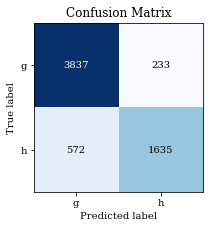

<IPython.core.display.Javascript object>

In [29]:
best_hyperparams = np.load("models/best_hyperparams_nn.npy")
best_batch_nn = best_hyperparams[0]
best_dropout_1 = best_hyperparams[1]
best_dropout_2 = best_hyperparams[2]
best_nodes_1 = best_hyperparams[3]
best_nodes_2 = best_hyperparams[4]

model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(best_nodes_1, activation="relu"),
        tf.keras.layers.Dropout(best_dropout_1),
        tf.keras.layers.Dense(best_nodes_2, activation="relu"),
        tf.keras.layers.Dropout(best_dropout_2),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)
model.compile(
    optimizer="adam", loss="categorical_crossentropy",
)
model.load_weights("models/best_nn_not_pca")

y_pred_train_nn = model.predict_classes(X_train.to_numpy()).reshape(-1, 1)
y_pred_train_nn = np.append(y_pred_train_nn == 0, y_pred_train_nn == 1, axis=1).astype(
    np.int
)

y_pred_test_nn = model.predict_classes(X_test.to_numpy()).reshape(-1, 1)
y_pred_test_nn = np.append(y_pred_test_nn == 0, y_pred_test_nn == 1, axis=1).astype(
    np.int
)

f1_score_weighted_train = sklme.f1_score(
    y_true=y_train, y_pred=y_pred_train_nn, average="weighted"
)

f1_score_weighted_test = sklme.f1_score(
    y_true=y_test, y_pred=y_pred_test_nn, average="weighted"
)


print("Neural Network:")
print(f"Train weighted f1 score: {f1_score_weighted_train:.2f}")
print(f"Test weighted f1 score: {f1_score_weighted_test:.2f}")
print(f"Best hyperparams: {best_hyperparams}")

fig, ax = plt.subplots(figsize=[3.01682, 3.01682])
sklplt.metrics.plot_confusion_matrix(
    encoder.inverse_transform(y_test.to_numpy()),
    encoder.inverse_transform(y_pred_test_nn),
    ax=ax,
)
ax.set_ylim([1.5, -0.5])
ax.set_xlim([-0.5, 1.5])
im = ax.images
cb = im[-1].colorbar
cb.remove()
fig.tight_layout()
fig.savefig("../doc/figures/nn_confusion_matrix.pdf", dpi=1000)
plt.show()

# XGBoost

In [30]:
y_train_boost = encoder.inverse_transform(y_train).ravel()
y_test_boost = encoder.inverse_transform(y_test).ravel()

y_train_split_boost = encoder.inverse_transform(y_train_split).ravel()
y_validation_boost = encoder.inverse_transform(y_validation).ravel()

validation_set_boost = [(X_validation, y_validation_boost)]

<IPython.core.display.Javascript object>

In [31]:
space_xg = [
    skopt.space.Real(low=1e-2, high=2e-1, prior="log-uniform", name="learning_rate"),
    skopt.space.Integer(low=1, high=10, name="max_tree_depth"),
    skopt.space.Real(low=1e-3, high=1e-1, prior="log-uniform", name="l1_alpha"),
    skopt.space.Real(low=1e-3, high=1e-1, prior="log-uniform", name="l2_lambda"),
    skopt.space.Integer(low=1, high=10, name="min_child_weight"),
]

<IPython.core.display.Javascript object>

In [32]:
@skopt.utils.use_named_args(dimensions=space_xg)
def xgboost_tune(
    learning_rate,
    max_tree_depth,
    l1_alpha,
    l2_lambda,
    min_child_weight,
    return_estimators=False,
):

    xgboost = xgb.XGBClassifier(
        objective="binary:logistic",
        n_jobs=-1,
        n_estimators=int(1e3),
        learning_rate=learning_rate,
        max_depth=max_tree_depth,
        reg_alpha=l1_alpha,
        reg_lambda=l2_lambda,
        min_child_weight=min_child_weight,
    ).fit(
        X=X_train_split,
        y=y_train_split_boost,
        eval_metric=["logloss"],
        eval_set=validation_set_boost,
        early_stopping_rounds=3,
        verbose=False,
    )

    y_pred_validation_boost = xgboost.predict(X_validation).reshape(-1, 1)
    f1_score_validation = sklme.f1_score(
        y_true=y_validation,
        y_pred=encoder.transform(y_pred_validation_boost),
        average="weighted",
    )

    if return_estimators:
        return xgboost.best_iteration

    return 1 - f1_score_validation

<IPython.core.display.Javascript object>

In [33]:
n_points_xg = 1000
optimizer_xgboost = skopt.gp_minimize(
    func=xgboost_tune,
    dimensions=space_xg,
    n_jobs=1,
    verbose=True,
    n_calls=n_points_xg,
    n_random_starts=n_points_xg,
)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.9451
Function value obtained: 0.1274
Current minimum: 0.1274
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.6569
Function value obtained: 0.1368
Current minimum: 0.1274
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.6644
Function value obtained: 0.1342
Current minimum: 0.1274
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3573
Function value obtained: 0.1307
Current minimum: 0.1274
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.5012
Function value obtained: 0.1486
Current minimum: 0.1274
Iteration No: 6 started. Evaluating

Iteration No: 43 ended. Evaluation done at random point.
Time taken: 1.4735
Function value obtained: 0.1259
Current minimum: 0.1218
Iteration No: 44 started. Evaluating function at random point.
Iteration No: 44 ended. Evaluation done at random point.
Time taken: 0.3348
Function value obtained: 0.1303
Current minimum: 0.1218
Iteration No: 45 started. Evaluating function at random point.
Iteration No: 45 ended. Evaluation done at random point.
Time taken: 0.7720
Function value obtained: 0.1313
Current minimum: 0.1218
Iteration No: 46 started. Evaluating function at random point.
Iteration No: 46 ended. Evaluation done at random point.
Time taken: 0.6919
Function value obtained: 0.1340
Current minimum: 0.1218
Iteration No: 47 started. Evaluating function at random point.
Iteration No: 47 ended. Evaluation done at random point.
Time taken: 0.6032
Function value obtained: 0.1239
Current minimum: 0.1218
Iteration No: 48 started. Evaluating function at random point.
Iteration No: 48 ended. E

Iteration No: 86 ended. Evaluation done at random point.
Time taken: 0.5524
Function value obtained: 0.1305
Current minimum: 0.1213
Iteration No: 87 started. Evaluating function at random point.
Iteration No: 87 ended. Evaluation done at random point.
Time taken: 0.3590
Function value obtained: 0.1254
Current minimum: 0.1213
Iteration No: 88 started. Evaluating function at random point.
Iteration No: 88 ended. Evaluation done at random point.
Time taken: 1.1722
Function value obtained: 0.1293
Current minimum: 0.1213
Iteration No: 89 started. Evaluating function at random point.
Iteration No: 89 ended. Evaluation done at random point.
Time taken: 0.4117
Function value obtained: 0.1521
Current minimum: 0.1213
Iteration No: 90 started. Evaluating function at random point.
Iteration No: 90 ended. Evaluation done at random point.
Time taken: 0.3268
Function value obtained: 0.1301
Current minimum: 0.1213
Iteration No: 91 started. Evaluating function at random point.
Iteration No: 91 ended. E

Iteration No: 128 ended. Evaluation done at random point.
Time taken: 2.2564
Function value obtained: 0.1305
Current minimum: 0.1193
Iteration No: 129 started. Evaluating function at random point.
Iteration No: 129 ended. Evaluation done at random point.
Time taken: 1.1745
Function value obtained: 0.1261
Current minimum: 0.1193
Iteration No: 130 started. Evaluating function at random point.
Iteration No: 130 ended. Evaluation done at random point.
Time taken: 0.6801
Function value obtained: 0.1242
Current minimum: 0.1193
Iteration No: 131 started. Evaluating function at random point.
Iteration No: 131 ended. Evaluation done at random point.
Time taken: 1.0527
Function value obtained: 0.1420
Current minimum: 0.1193
Iteration No: 132 started. Evaluating function at random point.
Iteration No: 132 ended. Evaluation done at random point.
Time taken: 0.1162
Function value obtained: 0.1380
Current minimum: 0.1193
Iteration No: 133 started. Evaluating function at random point.
Iteration No: 1

Iteration No: 170 ended. Evaluation done at random point.
Time taken: 1.8727
Function value obtained: 0.1251
Current minimum: 0.1193
Iteration No: 171 started. Evaluating function at random point.
Iteration No: 171 ended. Evaluation done at random point.
Time taken: 2.0368
Function value obtained: 0.1313
Current minimum: 0.1193
Iteration No: 172 started. Evaluating function at random point.
Iteration No: 172 ended. Evaluation done at random point.
Time taken: 0.4157
Function value obtained: 0.1365
Current minimum: 0.1193
Iteration No: 173 started. Evaluating function at random point.
Iteration No: 173 ended. Evaluation done at random point.
Time taken: 0.8741
Function value obtained: 0.1287
Current minimum: 0.1193
Iteration No: 174 started. Evaluating function at random point.
Iteration No: 174 ended. Evaluation done at random point.
Time taken: 0.2219
Function value obtained: 0.1391
Current minimum: 0.1193
Iteration No: 175 started. Evaluating function at random point.
Iteration No: 1

Iteration No: 212 ended. Evaluation done at random point.
Time taken: 0.7039
Function value obtained: 0.1420
Current minimum: 0.1169
Iteration No: 213 started. Evaluating function at random point.
Iteration No: 213 ended. Evaluation done at random point.
Time taken: 0.4663
Function value obtained: 0.1323
Current minimum: 0.1169
Iteration No: 214 started. Evaluating function at random point.
Iteration No: 214 ended. Evaluation done at random point.
Time taken: 0.8619
Function value obtained: 0.1236
Current minimum: 0.1169
Iteration No: 215 started. Evaluating function at random point.
Iteration No: 215 ended. Evaluation done at random point.
Time taken: 0.3194
Function value obtained: 0.1234
Current minimum: 0.1169
Iteration No: 216 started. Evaluating function at random point.
Iteration No: 216 ended. Evaluation done at random point.
Time taken: 1.2625
Function value obtained: 0.1330
Current minimum: 0.1169
Iteration No: 217 started. Evaluating function at random point.
Iteration No: 2

Iteration No: 254 ended. Evaluation done at random point.
Time taken: 0.4130
Function value obtained: 0.1259
Current minimum: 0.1169
Iteration No: 255 started. Evaluating function at random point.
Iteration No: 255 ended. Evaluation done at random point.
Time taken: 0.7930
Function value obtained: 0.1233
Current minimum: 0.1169
Iteration No: 256 started. Evaluating function at random point.
Iteration No: 256 ended. Evaluation done at random point.
Time taken: 1.3224
Function value obtained: 0.1268
Current minimum: 0.1169
Iteration No: 257 started. Evaluating function at random point.
Iteration No: 257 ended. Evaluation done at random point.
Time taken: 0.7357
Function value obtained: 0.1337
Current minimum: 0.1169
Iteration No: 258 started. Evaluating function at random point.
Iteration No: 258 ended. Evaluation done at random point.
Time taken: 0.2728
Function value obtained: 0.1313
Current minimum: 0.1169
Iteration No: 259 started. Evaluating function at random point.
Iteration No: 2

Iteration No: 296 ended. Evaluation done at random point.
Time taken: 1.1348
Function value obtained: 0.1330
Current minimum: 0.1169
Iteration No: 297 started. Evaluating function at random point.
Iteration No: 297 ended. Evaluation done at random point.
Time taken: 1.9501
Function value obtained: 0.1374
Current minimum: 0.1169
Iteration No: 298 started. Evaluating function at random point.
Iteration No: 298 ended. Evaluation done at random point.
Time taken: 0.8522
Function value obtained: 0.1602
Current minimum: 0.1169
Iteration No: 299 started. Evaluating function at random point.
Iteration No: 299 ended. Evaluation done at random point.
Time taken: 0.7276
Function value obtained: 0.1250
Current minimum: 0.1169
Iteration No: 300 started. Evaluating function at random point.
Iteration No: 300 ended. Evaluation done at random point.
Time taken: 0.6409
Function value obtained: 0.1383
Current minimum: 0.1169
Iteration No: 301 started. Evaluating function at random point.
Iteration No: 3

Iteration No: 338 ended. Evaluation done at random point.
Time taken: 0.3926
Function value obtained: 0.1289
Current minimum: 0.1169
Iteration No: 339 started. Evaluating function at random point.
Iteration No: 339 ended. Evaluation done at random point.
Time taken: 0.2853
Function value obtained: 0.1219
Current minimum: 0.1169
Iteration No: 340 started. Evaluating function at random point.
Iteration No: 340 ended. Evaluation done at random point.
Time taken: 0.3197
Function value obtained: 0.1247
Current minimum: 0.1169
Iteration No: 341 started. Evaluating function at random point.
Iteration No: 341 ended. Evaluation done at random point.
Time taken: 2.2981
Function value obtained: 0.1225
Current minimum: 0.1169
Iteration No: 342 started. Evaluating function at random point.
Iteration No: 342 ended. Evaluation done at random point.
Time taken: 0.6657
Function value obtained: 0.1313
Current minimum: 0.1169
Iteration No: 343 started. Evaluating function at random point.
Iteration No: 3

Iteration No: 380 ended. Evaluation done at random point.
Time taken: 1.1462
Function value obtained: 0.1225
Current minimum: 0.1169
Iteration No: 381 started. Evaluating function at random point.
Iteration No: 381 ended. Evaluation done at random point.
Time taken: 1.7258
Function value obtained: 0.1419
Current minimum: 0.1169
Iteration No: 382 started. Evaluating function at random point.
Iteration No: 382 ended. Evaluation done at random point.
Time taken: 3.0085
Function value obtained: 0.1294
Current minimum: 0.1169
Iteration No: 383 started. Evaluating function at random point.
Iteration No: 383 ended. Evaluation done at random point.
Time taken: 0.7806
Function value obtained: 0.1402
Current minimum: 0.1169
Iteration No: 384 started. Evaluating function at random point.
Iteration No: 384 ended. Evaluation done at random point.
Time taken: 0.2502
Function value obtained: 0.1321
Current minimum: 0.1169
Iteration No: 385 started. Evaluating function at random point.
Iteration No: 3

Iteration No: 423 ended. Evaluation done at random point.
Time taken: 0.6574
Function value obtained: 0.1223
Current minimum: 0.1169
Iteration No: 424 started. Evaluating function at random point.
Iteration No: 424 ended. Evaluation done at random point.
Time taken: 1.2057
Function value obtained: 0.1284
Current minimum: 0.1169
Iteration No: 425 started. Evaluating function at random point.
Iteration No: 425 ended. Evaluation done at random point.
Time taken: 0.9124
Function value obtained: 0.1354
Current minimum: 0.1169
Iteration No: 426 started. Evaluating function at random point.
Iteration No: 426 ended. Evaluation done at random point.
Time taken: 0.6058
Function value obtained: 0.1394
Current minimum: 0.1169
Iteration No: 427 started. Evaluating function at random point.
Iteration No: 427 ended. Evaluation done at random point.
Time taken: 3.0565
Function value obtained: 0.1312
Current minimum: 0.1169
Iteration No: 428 started. Evaluating function at random point.
Iteration No: 4

Iteration No: 465 ended. Evaluation done at random point.
Time taken: 2.8960
Function value obtained: 0.1365
Current minimum: 0.1169
Iteration No: 466 started. Evaluating function at random point.
Iteration No: 466 ended. Evaluation done at random point.
Time taken: 0.2789
Function value obtained: 0.1372
Current minimum: 0.1169
Iteration No: 467 started. Evaluating function at random point.
Iteration No: 467 ended. Evaluation done at random point.
Time taken: 0.5411
Function value obtained: 0.1268
Current minimum: 0.1169
Iteration No: 468 started. Evaluating function at random point.
Iteration No: 468 ended. Evaluation done at random point.
Time taken: 1.7772
Function value obtained: 0.1368
Current minimum: 0.1169
Iteration No: 469 started. Evaluating function at random point.
Iteration No: 469 ended. Evaluation done at random point.
Time taken: 0.5708
Function value obtained: 0.1249
Current minimum: 0.1169
Iteration No: 470 started. Evaluating function at random point.
Iteration No: 4

Iteration No: 507 ended. Evaluation done at random point.
Time taken: 1.9092
Function value obtained: 0.1260
Current minimum: 0.1169
Iteration No: 508 started. Evaluating function at random point.
Iteration No: 508 ended. Evaluation done at random point.
Time taken: 0.6734
Function value obtained: 0.1266
Current minimum: 0.1169
Iteration No: 509 started. Evaluating function at random point.
Iteration No: 509 ended. Evaluation done at random point.
Time taken: 0.1609
Function value obtained: 0.1317
Current minimum: 0.1169
Iteration No: 510 started. Evaluating function at random point.
Iteration No: 510 ended. Evaluation done at random point.
Time taken: 0.2452
Function value obtained: 0.1404
Current minimum: 0.1169
Iteration No: 511 started. Evaluating function at random point.
Iteration No: 511 ended. Evaluation done at random point.
Time taken: 2.4005
Function value obtained: 0.1231
Current minimum: 0.1169
Iteration No: 512 started. Evaluating function at random point.
Iteration No: 5

Iteration No: 549 ended. Evaluation done at random point.
Time taken: 2.1847
Function value obtained: 0.1332
Current minimum: 0.1169
Iteration No: 550 started. Evaluating function at random point.
Iteration No: 550 ended. Evaluation done at random point.
Time taken: 0.6414
Function value obtained: 0.1286
Current minimum: 0.1169
Iteration No: 551 started. Evaluating function at random point.
Iteration No: 551 ended. Evaluation done at random point.
Time taken: 0.2628
Function value obtained: 0.1239
Current minimum: 0.1169
Iteration No: 552 started. Evaluating function at random point.
Iteration No: 552 ended. Evaluation done at random point.
Time taken: 0.3092
Function value obtained: 0.1207
Current minimum: 0.1169
Iteration No: 553 started. Evaluating function at random point.
Iteration No: 553 ended. Evaluation done at random point.
Time taken: 0.2941
Function value obtained: 0.1357
Current minimum: 0.1169
Iteration No: 554 started. Evaluating function at random point.
Iteration No: 5

Iteration No: 591 ended. Evaluation done at random point.
Time taken: 0.2221
Function value obtained: 0.1295
Current minimum: 0.1169
Iteration No: 592 started. Evaluating function at random point.
Iteration No: 592 ended. Evaluation done at random point.
Time taken: 1.4980
Function value obtained: 0.1233
Current minimum: 0.1169
Iteration No: 593 started. Evaluating function at random point.
Iteration No: 593 ended. Evaluation done at random point.
Time taken: 0.1761
Function value obtained: 0.1571
Current minimum: 0.1169
Iteration No: 594 started. Evaluating function at random point.
Iteration No: 594 ended. Evaluation done at random point.
Time taken: 0.3546
Function value obtained: 0.1413
Current minimum: 0.1169
Iteration No: 595 started. Evaluating function at random point.
Iteration No: 595 ended. Evaluation done at random point.
Time taken: 0.4254
Function value obtained: 0.1306
Current minimum: 0.1169
Iteration No: 596 started. Evaluating function at random point.
Iteration No: 5

Iteration No: 633 ended. Evaluation done at random point.
Time taken: 3.4621
Function value obtained: 0.1240
Current minimum: 0.1169
Iteration No: 634 started. Evaluating function at random point.
Iteration No: 634 ended. Evaluation done at random point.
Time taken: 0.6170
Function value obtained: 0.1376
Current minimum: 0.1169
Iteration No: 635 started. Evaluating function at random point.
Iteration No: 635 ended. Evaluation done at random point.
Time taken: 0.3895
Function value obtained: 0.1291
Current minimum: 0.1169
Iteration No: 636 started. Evaluating function at random point.
Iteration No: 636 ended. Evaluation done at random point.
Time taken: 0.4413
Function value obtained: 0.1388
Current minimum: 0.1169
Iteration No: 637 started. Evaluating function at random point.
Iteration No: 637 ended. Evaluation done at random point.
Time taken: 0.8585
Function value obtained: 0.1278
Current minimum: 0.1169
Iteration No: 638 started. Evaluating function at random point.
Iteration No: 6

Iteration No: 675 ended. Evaluation done at random point.
Time taken: 1.5922
Function value obtained: 0.1385
Current minimum: 0.1169
Iteration No: 676 started. Evaluating function at random point.
Iteration No: 676 ended. Evaluation done at random point.
Time taken: 1.3308
Function value obtained: 0.1377
Current minimum: 0.1169
Iteration No: 677 started. Evaluating function at random point.
Iteration No: 677 ended. Evaluation done at random point.
Time taken: 1.3076
Function value obtained: 0.1330
Current minimum: 0.1169
Iteration No: 678 started. Evaluating function at random point.
Iteration No: 678 ended. Evaluation done at random point.
Time taken: 2.4090
Function value obtained: 0.1203
Current minimum: 0.1169
Iteration No: 679 started. Evaluating function at random point.
Iteration No: 679 ended. Evaluation done at random point.
Time taken: 0.5308
Function value obtained: 0.1321
Current minimum: 0.1169
Iteration No: 680 started. Evaluating function at random point.
Iteration No: 6

Iteration No: 717 ended. Evaluation done at random point.
Time taken: 0.9431
Function value obtained: 0.1285
Current minimum: 0.1169
Iteration No: 718 started. Evaluating function at random point.
Iteration No: 718 ended. Evaluation done at random point.
Time taken: 0.6365
Function value obtained: 0.1323
Current minimum: 0.1169
Iteration No: 719 started. Evaluating function at random point.
Iteration No: 719 ended. Evaluation done at random point.
Time taken: 0.7071
Function value obtained: 0.1247
Current minimum: 0.1169
Iteration No: 720 started. Evaluating function at random point.
Iteration No: 720 ended. Evaluation done at random point.
Time taken: 0.4252
Function value obtained: 0.1290
Current minimum: 0.1169
Iteration No: 721 started. Evaluating function at random point.
Iteration No: 721 ended. Evaluation done at random point.
Time taken: 0.5110
Function value obtained: 0.1381
Current minimum: 0.1169
Iteration No: 722 started. Evaluating function at random point.
Iteration No: 7

Iteration No: 759 ended. Evaluation done at random point.
Time taken: 0.5041
Function value obtained: 0.1241
Current minimum: 0.1169
Iteration No: 760 started. Evaluating function at random point.
Iteration No: 760 ended. Evaluation done at random point.
Time taken: 1.1606
Function value obtained: 0.1234
Current minimum: 0.1169
Iteration No: 761 started. Evaluating function at random point.
Iteration No: 761 ended. Evaluation done at random point.
Time taken: 0.6175
Function value obtained: 0.1263
Current minimum: 0.1169
Iteration No: 762 started. Evaluating function at random point.
Iteration No: 762 ended. Evaluation done at random point.
Time taken: 1.1704
Function value obtained: 0.1274
Current minimum: 0.1169
Iteration No: 763 started. Evaluating function at random point.
Iteration No: 763 ended. Evaluation done at random point.
Time taken: 1.0095
Function value obtained: 0.1346
Current minimum: 0.1169
Iteration No: 764 started. Evaluating function at random point.
Iteration No: 7

Iteration No: 801 ended. Evaluation done at random point.
Time taken: 1.1575
Function value obtained: 0.1306
Current minimum: 0.1169
Iteration No: 802 started. Evaluating function at random point.
Iteration No: 802 ended. Evaluation done at random point.
Time taken: 0.8186
Function value obtained: 0.1521
Current minimum: 0.1169
Iteration No: 803 started. Evaluating function at random point.
Iteration No: 803 ended. Evaluation done at random point.
Time taken: 0.9445
Function value obtained: 0.1376
Current minimum: 0.1169
Iteration No: 804 started. Evaluating function at random point.
Iteration No: 804 ended. Evaluation done at random point.
Time taken: 2.1476
Function value obtained: 0.1280
Current minimum: 0.1169
Iteration No: 805 started. Evaluating function at random point.
Iteration No: 805 ended. Evaluation done at random point.
Time taken: 2.8367
Function value obtained: 0.1404
Current minimum: 0.1169
Iteration No: 806 started. Evaluating function at random point.
Iteration No: 8

Iteration No: 843 ended. Evaluation done at random point.
Time taken: 0.9425
Function value obtained: 0.1421
Current minimum: 0.1169
Iteration No: 844 started. Evaluating function at random point.
Iteration No: 844 ended. Evaluation done at random point.
Time taken: 1.4132
Function value obtained: 0.1243
Current minimum: 0.1169
Iteration No: 845 started. Evaluating function at random point.
Iteration No: 845 ended. Evaluation done at random point.
Time taken: 0.2565
Function value obtained: 0.1331
Current minimum: 0.1169
Iteration No: 846 started. Evaluating function at random point.
Iteration No: 846 ended. Evaluation done at random point.
Time taken: 2.1697
Function value obtained: 0.1352
Current minimum: 0.1169
Iteration No: 847 started. Evaluating function at random point.
Iteration No: 847 ended. Evaluation done at random point.
Time taken: 0.3531
Function value obtained: 0.1255
Current minimum: 0.1169
Iteration No: 848 started. Evaluating function at random point.
Iteration No: 8

Iteration No: 885 ended. Evaluation done at random point.
Time taken: 1.0130
Function value obtained: 0.1208
Current minimum: 0.1169
Iteration No: 886 started. Evaluating function at random point.
Iteration No: 886 ended. Evaluation done at random point.
Time taken: 0.4904
Function value obtained: 0.1296
Current minimum: 0.1169
Iteration No: 887 started. Evaluating function at random point.
Iteration No: 887 ended. Evaluation done at random point.
Time taken: 0.1834
Function value obtained: 0.1331
Current minimum: 0.1169
Iteration No: 888 started. Evaluating function at random point.
Iteration No: 888 ended. Evaluation done at random point.
Time taken: 0.2736
Function value obtained: 0.1299
Current minimum: 0.1169
Iteration No: 889 started. Evaluating function at random point.
Iteration No: 889 ended. Evaluation done at random point.
Time taken: 2.0020
Function value obtained: 0.1367
Current minimum: 0.1169
Iteration No: 890 started. Evaluating function at random point.
Iteration No: 8

Iteration No: 928 ended. Evaluation done at random point.
Time taken: 0.7727
Function value obtained: 0.1306
Current minimum: 0.1169
Iteration No: 929 started. Evaluating function at random point.
Iteration No: 929 ended. Evaluation done at random point.
Time taken: 0.3878
Function value obtained: 0.1355
Current minimum: 0.1169
Iteration No: 930 started. Evaluating function at random point.
Iteration No: 930 ended. Evaluation done at random point.
Time taken: 2.9544
Function value obtained: 0.1269
Current minimum: 0.1169
Iteration No: 931 started. Evaluating function at random point.
Iteration No: 931 ended. Evaluation done at random point.
Time taken: 1.1658
Function value obtained: 0.1251
Current minimum: 0.1169
Iteration No: 932 started. Evaluating function at random point.
Iteration No: 932 ended. Evaluation done at random point.
Time taken: 1.0864
Function value obtained: 0.1277
Current minimum: 0.1169
Iteration No: 933 started. Evaluating function at random point.
Iteration No: 9

Iteration No: 970 ended. Evaluation done at random point.
Time taken: 0.7306
Function value obtained: 0.1261
Current minimum: 0.1169
Iteration No: 971 started. Evaluating function at random point.
Iteration No: 971 ended. Evaluation done at random point.
Time taken: 2.3939
Function value obtained: 0.1266
Current minimum: 0.1169
Iteration No: 972 started. Evaluating function at random point.
Iteration No: 972 ended. Evaluation done at random point.
Time taken: 0.9086
Function value obtained: 0.1341
Current minimum: 0.1169
Iteration No: 973 started. Evaluating function at random point.
Iteration No: 973 ended. Evaluation done at random point.
Time taken: 0.2039
Function value obtained: 0.1546
Current minimum: 0.1169
Iteration No: 974 started. Evaluating function at random point.
Iteration No: 974 ended. Evaluation done at random point.
Time taken: 0.2828
Function value obtained: 0.1207
Current minimum: 0.1169
Iteration No: 975 started. Evaluating function at random point.
Iteration No: 9

<IPython.core.display.Javascript object>

In [34]:
(
    best_learning_rate,
    best_max_tree_depth,
    best_l1_alpha,
    best_l2_lambda,
    best_min_child_weight,
) = optimizer_xgboost["x"]

print(
    best_learning_rate,
    best_max_tree_depth,
    best_l1_alpha,
    best_l2_lambda,
    best_min_child_weight,
)

best_n_estimators = xgboost_tune.__wrapped__(
    best_learning_rate,
    best_max_tree_depth,
    best_l1_alpha,
    best_l2_lambda,
    best_min_child_weight,
    return_estimators=True,
)
print(best_n_estimators)

0.04816379830160162 9 0.007460566109135296 0.0035695005914375133 3
125


<IPython.core.display.Javascript object>

In [35]:
xgboost_refit = xgb.XGBClassifier(
    objective="binary:logistic",
    n_jobs=-1,
    n_estimators=best_n_estimators,
    learning_rate=best_learning_rate,
    max_depth=best_max_tree_depth,
    reg_alpha=best_l1_alpha,
    reg_lambda=best_l2_lambda,
    min_child_weight=best_min_child_weight,
    verbose=True,
).fit(X_train, y_train_boost)

joblib.dump(xgboost_refit, "models/xgboost_refit.pkl")
np.save(
    "models/best_hyperparams_xgboost.npy",
    np.array(optimizer_xgboost["x"], dtype=object),
)

<IPython.core.display.Javascript object>

In [36]:
best_hyperparams_xgboost = dict(
    zip(
        ["learning_rate", "max_depth", "reg_alpha", "reg_lambda", "min_child_weight",],
        np.load("models/best_hyperparams_xgboost.npy", allow_pickle=True),
    )
)
xgboost_refit = joblib.load("models/xgboost_refit.pkl")

<IPython.core.display.Javascript object>

XGBoost:
Train weighted f1 score: 0.95
Test weighted f1 score: 0.88


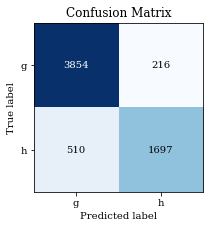

<IPython.core.display.Javascript object>

In [37]:
y_pred_train_boost = xgboost_refit.predict(X_train).reshape(-1, 1)
y_pred_test_boost = xgboost_refit.predict(X_test).reshape(-1, 1)

f1_score_weighted_train_boost = sklme.f1_score(
    y_true=y_train, y_pred=encoder.transform(y_pred_train_boost), average="weighted"
)

f1_score_weighted_test_boost = sklme.f1_score(
    y_true=y_test, y_pred=encoder.transform(y_pred_test_boost), average="weighted"
)

print("XGBoost:")
print(f"Train weighted f1 score: {f1_score_weighted_train_boost:.2f}")
print(f"Test weighted f1 score: {f1_score_weighted_test_boost:.2f}")


fig, ax = plt.subplots(figsize=[3.01682, 3.01682])
sklplt.metrics.plot_confusion_matrix(
    encoder.inverse_transform(y_test.to_numpy()), y_pred_test_boost, ax=ax,
)

ax.set_ylim([1.5, -0.5])
ax.set_xlim([-0.5, 1.5])
im = ax.images
cb = im[-1].colorbar
cb.remove()
fig.tight_layout()
fig.savefig("../doc/figures/xgboost_confusion_matrix.pdf", dpi=1000)
plt.show()

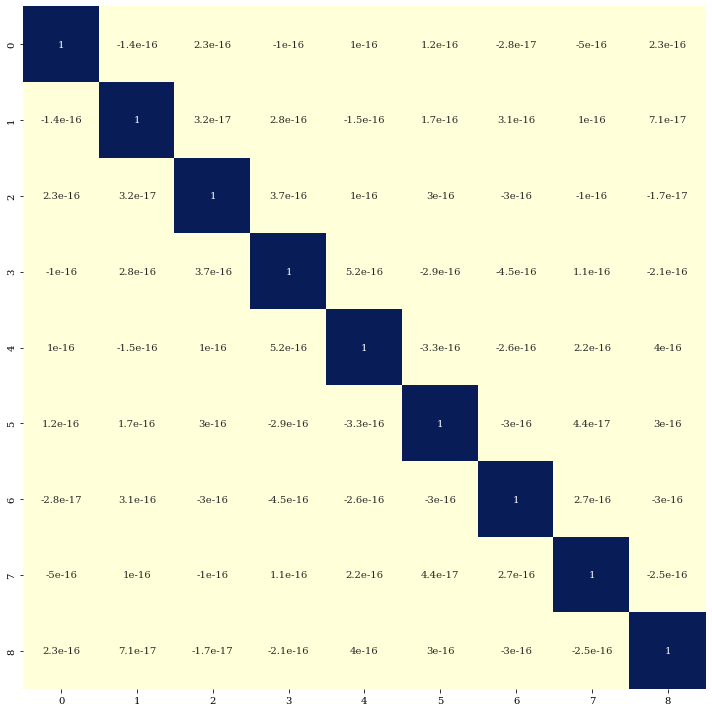

<IPython.core.display.Javascript object>

In [38]:
pca = sklde.PCA(n_components="mle")
X_train_pca = pd.DataFrame(pca.fit_transform(X_train))
X_test_pca = pd.DataFrame(pca.transform(X_test))
fig, ax = plt.subplots(figsize=(10 * 1.618, 10))
sns.heatmap(
    X_train_pca.corr(), cmap="YlGnBu", ax=ax, square=True, annot=True, cbar=False
)
ax.set_ylim([9, 0])
ax.set_xlim([0, 9])
fig.tight_layout()
plt.show()